# Checksum Failure Analysis

***By Ali Lotfollahi***

## Abstract

In this notebook, our goal is to compute the probability of UDP checksum failing to detect an existing error. Our inputs in this project are the probability by which a bit alters and also the size of the UDP segment.

## Formulation

Parameters are defined as follows:
- the probability with which a bit is altered is shown by $p$.
- *the size of a segment* is denoted as $n'$.
- *lines of UDP segment sent from the sender*: $Lines$, a binary ($n' \times 32$) matrix.
- *lines of UDP segment received at the receiver*: $Lines'$, a binary ($n' \times 32$) matrix.

Based on $Lines$ and $Lines'$, we can define $Fields$ and $Fields'$ the following way:
$$
    Fields[i, 1:16] := \begin{cases}
        Lines[k,1:16] &; i = 2k + 1 \\
        Lines[k,17:32] &; i = 2k
    \end{cases}
$$

$$
    Fields'[i, 1:16] := \begin{cases}
        Lines'[k,1:16] &; i = 2k + 1 \\
        Lines'[k,17:32] &; i = 2k
    \end{cases}
$$

We know:
- $Fields[1]$ and $Fields[2]$ represent *source port number* and *destination port number* respectively.
- $Fields[3]$ demonstrates $n'$.
- $Fields[4]$ is the *checksum error* that causes the following equation:
$$
    \sum_{i=1}^{2n'} Field[i] = 0
$$
where the zero in 1's complement is represented as both $1_{16}$ and $0_{16}$.

From now on, to avoid unnecessary complications, we define $n$ to be equal to $2n'$

### The Goal

The goal of this notebook is to calculate the following probability:
$$
    Pr(\text{Undetected error}) = Pr(\sum_{i=1}^{n} Fields'[i] = 0) - Pr(\text{No alteration})
$$

Now, if we define:
$$ \Delta[i] := Fields'[i] - Fields[i] $$
the following will be true:
$$ \sum_{i=1}^{n} Fields'[i] = 0 \longleftrightarrow \sum_{i=1}^{n} \Delta[i] = 0

## Parameters

(`M` is put here just for the sake of simplicity)

In [1]:
P = 0.01
N = 100
M = 2 ** 16 - 1

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Recursive Programming

The approach taken to find the probability of $\sum_{i=1}^{2n} \Delta[i] = 0$ is recursive programming.

### `f[n, k]`

At first, we define $f[n, k]$ the following way:
$$
    f[n, k]:= \text{chance of } \sum_{i = 1}^{n} \Delta[i] = k
$$

Now, it is provable to assume:
$$
    \forall j \in [1, n): f[n, k] = \sum_{x = 0}^{2^{16} - 2} f[j, x]f[n - j, k - x]
$$
which could be interpreted:
$$
    \forall j \in [1, n): f[n] = \text{convolution of } (f[j], f[n - j])
$$

In [3]:
f = np.zeros((N + 1, M), dtype=np.float128)

Because $\sum_{i=1}^{0} \Delta[i] = 0$ is always true, then 
$$f[0, 0] = 1$$ 
and 
$$\forall k > 0: f[0, k] = 0$$

In [4]:
f[0, 0] = 1

If number of 1s in the 16-bit binary representation of $k$ is denoted by $\lambda(k)$, the chance of $\Delta = k$ when $k \neq 0$ is computed as follows: 
$$f[1, k] = p^{\lambda(k)}\times (1-p)^{16 - \lambda(k)}$$
For $k = 0$, we have: 
$$ f[1, 0] = p^{0}(1-p)^{16} + p^{16}(1-p)^{0} = (1-p)^{16} + p^{16}$$

In [5]:
binary = np.fromfunction(lambda x: x, (M + 1, ), dtype=np.uint16)
binary_repr = np.vectorize(np.binary_repr, otypes=[str])
binary = np.char.count(binary_repr(binary), '1')
prob = np.array((P ** binary) * ((1-P)**(16 - binary)), dtype=np.float128)
f[1] = prob[:-1]
f[1, 0] += prob[-1]
f

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.51457771e-01, 8.60058355e-03, 8.60058355e-03, ...,
        9.80100000e-29, 9.90000000e-31, 9.90000000e-31],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float128)

### `calculated`

This array demonstrates which rows of `f` are calculated so far. It is basically put to avoid recalculation of rows.

In [6]:
calculated = np.zeros(N + 1, dtype=np.bool_)
calculated[0] = calculated[1] = True
calculated

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

### Definition of Recursive Function `calc`

`calc` function is the bread and butter of this analysis. It gets the number of $\Delta$ values as its input to then compute `f[n]` if `calculated[n]` is not `True`. Next, it searches for a `j` so that both `calculated[j]` and `calculated[n - j]` are `True`. If such `j` is not found, `calc` calls itself on $\lfloor \frac{n}{2} \rfloor$ and $n - \lfloor \frac{n}{2} \rfloor$ and sets `j` to $\lfloor \frac{n}{2} \rfloor$.

Thereafter, when the prerequisite rows are selected, the convolution of them is computed and then stored in `convolved`.

At last, `f[n]` is calculated by `convolved` provided that in 16-bit, 1's-complement binary representation, if $x > 2^{16} - 2$, it will be represented by $x \% (2^{16} - 1)$.

In [7]:
def calc(n):
    if calculated[n]:
        return
    j = -1
    for i in range(1, int(n / 2) + 1):
        if calculated[i] and calculated[n - i]:
            j = i
            break
    if j == -1:
        j = int(n / 2)
        calc(j)
        calc(n - j)
    
    convolved = np.convolve(f[j], f[n - j])
    f[n] = convolved[:M] + np.concatenate([convolved[M:], np.array([0])])
    calculated[n] = True

## Computation

### Calling `calc` Function

In [8]:
calc(N)
f

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.51457771e-01, 8.60058355e-03, 8.60058355e-03, ...,
        9.80100000e-29, 9.90000000e-31, 9.90000000e-31],
       [7.24980336e-01, 1.47215626e-02, 1.47215626e-02, ...,
        1.37434800e-24, 2.77617735e-26, 2.77617735e-26],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.05473368e-06, 7.11080744e-06, 7.11080744e-06, ...,
        5.93985773e-06, 5.08259312e-06, 5.08259312e-06]], dtype=float128)

### Demonstration of What Rows of `f` Has Been Computed

In [9]:
np.arange(N + 1)[calculated]

array([  0,   1,   2,   3,   6,  12,  13,  25,  50, 100])

### Plot of `f[n, 0]` Over `n` $\in [0, N]$

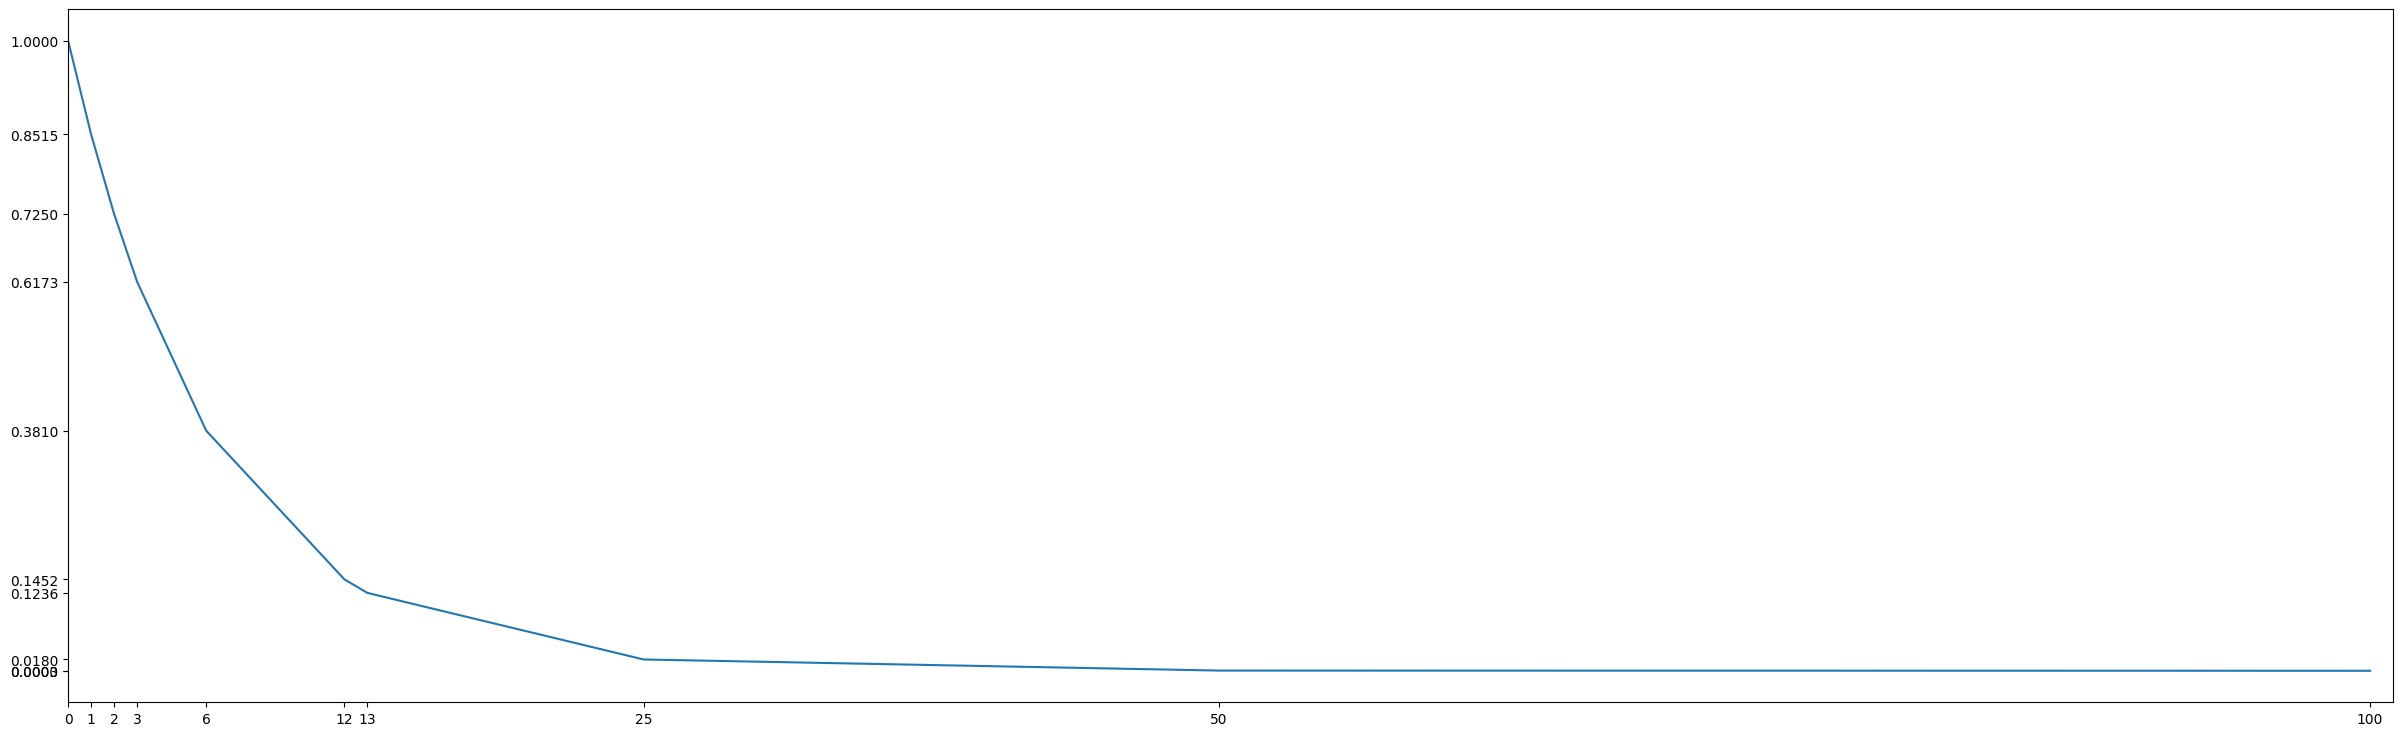

In [13]:
fig, ax = plt.subplots()
X = np.arange(N + 1)[calculated]
Y = f[calculated, 0]
ax.plot(X, Y)

ax.set_xticks(np.arange(N + 1)[calculated])
ax.set_yticks(f[calculated, 0])
ax.set_xlim(0, N + 1)
fig.set_size_inches(30, 9)
plt.show()

### Calculating the Probability of an Undetected Error

$$
    Pr(\text{Undetected error}) = Pr(\sum_{i=1}^{n} \Delta[i] = 0) - Pr(\text{No alteration})
$$

#### Important Notice

Do notice that we assumed both $\sum fields'[i] = 0$ and $\sum fields'[i] = 2^{16} - 1$ show that no error existed. In UDP checksum, however, only the latter shows that no error existed. This assumption was made in order to avoid letting in all the $fields$ and $fields'$ values. Because in that case the probability of checksum not detecting an existing error will be:
$$
    Pr(\text{Undetected error}) = Pr(\sum_{i=1}^{n} \Delta[i] = 0) - Pr(\text{No alteration}) - Pr(\sum_{i=1}^{n} fields'[i] = 0)
$$
in which to compute $Pr(\sum_{i=1}^{n} fields'[i] = 0)$ the values of $fields'$ are needed.

In [11]:
p = f[N, 0] - (1 - P) ** (16 * N)
print(f'The probability is {p:.10f}')

The probability is 0.0000039509


## Conclusion

This article finishes here by computing the probability of not detecting an existing error using UDP checksum. This shows how unlikely it is for UDP checksum to fail finding an error. Therefore, we have proved by the theory of statistics, how valuable it is to put a simple checksum field in a UDP segment.